## Pràctica 8


In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import Math, display
import sympy as sp
from sympy.physics.units.systems import SI
from sympy.physics.units import meter, second, liter, hour, degree, convert_to
from sympy import sin, cos, pi, Abs
import simpy

sp.init_printing()

def show(*args):
    out = ""
    for arg in args:
        if isinstance(arg, (sp.Expr, sp.Eq)):
            arg = sp.latex(arg)
        else:
            arg = str(arg)
        out += arg
    display(Math(out))

qq = "\quad "

<>:25: SyntaxWarning: invalid escape sequence '\q'
<>:25: SyntaxWarning: invalid escape sequence '\q'
C:\Users\samon\AppData\Local\Temp\ipykernel_19264\4176397549.py:25: SyntaxWarning: invalid escape sequence '\q'
  qq = "\quad "


### Exercici 1
- A una cabina experimental es genera ozó, que és un gas tòxic que volem extreure.
- Hem modelitzat l'extracció d'ozó de la següent manera:
$$x'  = -x \cdot Q/V + O \cdot R $$

on $x$ representa la concentració del gas, $Q$ representa el flux d'extracció d'aire, $V$ és el volum de l'habitació, $O$ és la concentració d'oxigen a l'aire i $R$ és el ritme de generació d'ozó.

Els valors mesurats dels paràmetres són els següents:
- La generació d'ozó es produeix a un ritme d'una molècula d'ozó per cada $(3.7 \pm 0.1) \times 10^9$ molècules d'oxigen per segon.
- La concentració d'oxigen a l'aire és de $20.9476 \pm 0.0005 \%$
- La cabina experimental té un volum de $125.4 \pm 0.8 \, m^3$


#### Dades
- Per validar el model hem fet unes proves irradiant un volum d'aire amb un extractor.
    - Volum d'aire $1.0000 \pm 1\times10^{-4} m^3$
    - Cabal d'aire de l'extractor $1.0 \pm 0.1 \,l/s$
    - La precisió de les mesures de concentració és de $1\times10^{-3}$ ppm

Index(['t (s)', 'Concentració (ppm)'], dtype='object')


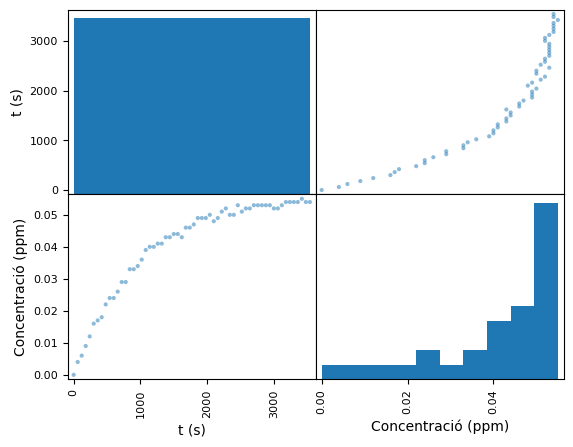

In [2]:
# Dades
data = pd.read_csv("https://raw.githubusercontent.com/gjover/modelitzacio/refs/heads/main/data/ozo.csv")
print(data.columns)
l = pd.plotting.scatter_matrix(data[data.columns])

- Fes la validació del model i una anàlisi crítica considerant que l'ozó és tòxic a concentracions de 5 ppm i el seu nivell de seguretat és de 0.1 ppm

### Definició dels errors

Per calcular l'error del cas $R$, ja que al model sustituïrem $1/R$:
$$R = \frac{1}{a}$$  $$a = 3.7 \cdot 10^9$$  $$U_a = 0.1\cdot 10^9$$ $$U_R = \left| \frac{dR}{da} \right| \cdot U_a = \frac{1}{a^2}U_a = \frac{0.1 \cdot 10^9}{(3.7 \cdot 10^9)} = 7.304 \cdot 10^{-12} $$

En altre cas, per exemple, $R = a^2$ l'únic que canviaria és la derivada.$$$$

In [3]:
times = data['t (s)'].values

### Pas 1 definim l'equació i la resolevm:

In [4]:
from IPython.display import display, Math
from scipy.integrate import odeint


t, Q, V, O, R = sp.symbols('t Q V O R', real=True, positive=True)
u_q, u_r, u_v, u_o = sp.symbols('u_q u_r u_v u_o', positive=True)


x = sp.Function('x')(t)
xp = sp.diff(x, t)

fx = -x*Q/V + O*R

eq = sp.Eq(xp, fx)
ics = {x.subs(t,0): 0}

In [5]:
valors_validacio = {
    Q : 1e-3,
    V : 1,
    O : 20.9476/100,
    R : 1/(3.7*1e9),
}

a) Amb la funció sp.dsvole (solució anàlita)

In [6]:
sol = sp.dsolve(eq, x, ics=ics) 
xt = sol.rhs * 1e6

display(Math(f"x(t) = {sp.latex(xt)}"))

<IPython.core.display.Math object>

In [7]:
# Definim la incertesa del model aquí pq més endavant petaU_x = sp.Function('U_x')(Q, R, V, O, t)

U_x = ((sp.diff(xt, Q)*u_q)**2 + (sp.diff(xt, R)*u_r)**2 + (sp.diff(xt, V)*u_v)**2 + (sp.diff(xt, O)*u_o)**2)**0.5

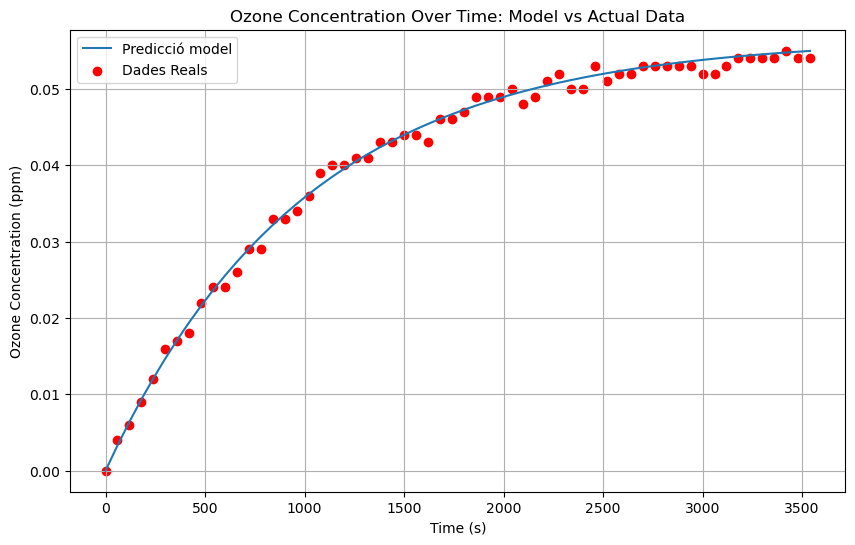

In [8]:
xt.subs(valors_validacio)
fxt = sp.lambdify(t, xt.subs(valors_validacio))

prediccions = fxt(times)

# Definim figura
plt.figure(figsize=(10, 6))
# Fem plot lineal de la predicció del model
plt.plot(times, prediccions, label='Predicció model')

# Plot dels data points de les dades reals
plt.scatter(times, data['Concentració (ppm)'], color='red', label='Dades Reals')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Ozone Concentration (ppm)')
plt.title('Ozone Concentration Over Time: Model vs Actual Data')
plt.legend()
plt.grid(True)

b) Amb la funció odeint (solució numèrica)

In [9]:
# Definm els valors
"""
Q = 1.0e-3
V = 1.0
O = 20.9476 / 100
R = 1.0 / (3.7e9)

# Definim la función derivada
def model(x, t):
    return -x * Q / V + O * R

# Condición inicial
x0 = 0

# Resolvem la edo
x_solution = odeint(model, x0, times)

# Convertir a ppm
x_ppm = x_solution.flatten() * 1e6
x_ppm
"""

'\nQ = 1.0e-3\nV = 1.0\nO = 20.9476 / 100\nR = 1.0 / (3.7e9)\n\n# Definim la función derivada\ndef model(x, t):\n    return -x * Q / V + O * R\n\n# Condición inicial\nx0 = 0\n\n# Resolvem la edo\nx_solution = odeint(model, x0, times)\n\n# Convertir a ppm\nx_ppm = x_solution.flatten() * 1e6\nx_ppm\n'

In [10]:
"""
# Definim figura
plt.figure(figsize=(10, 6))
# Fem plot lineal de la predicció del model
plt.plot(times, x_ppm, label='Predicció model')

# Plot dels data points de les dades reals
plt.scatter(times, data['Concentració (ppm)'], color='red', label='Dades Reals')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Ozone Concentration (ppm)')
plt.title('Ozone Concentration Over Time: Model vs Actual Data')
plt.legend()
plt.grid(True)
"""

"\n# Definim figura\nplt.figure(figsize=(10, 6))\n# Fem plot lineal de la predicció del model\nplt.plot(times, x_ppm, label='Predicció model')\n\n# Plot dels data points de les dades reals\nplt.scatter(times, data['Concentració (ppm)'], color='red', label='Dades Reals')\n\n# Add labels and legend\nplt.xlabel('Time (s)')\nplt.ylabel('Ozone Concentration (ppm)')\nplt.title('Ozone Concentration Over Time: Model vs Actual Data')\nplt.legend()\nplt.grid(True)\n"

### Pas 2 calculem la discrèpancia del model

$D = S - P$

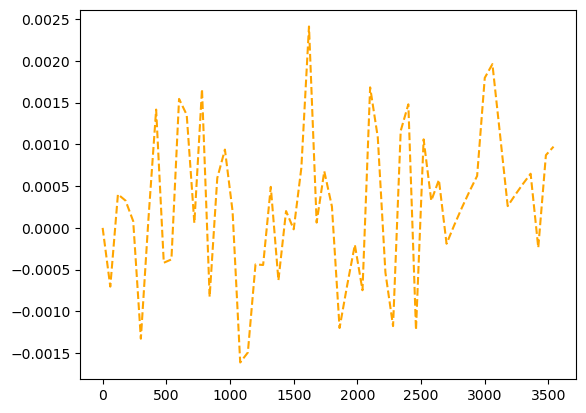

In [11]:
E_p = prediccions - data['Concentració (ppm)']
plt.plot(times, E_p, label='Discrepancies', color='orange', linestyle='--')

Mean discrepancy: 0.00027158948741160216


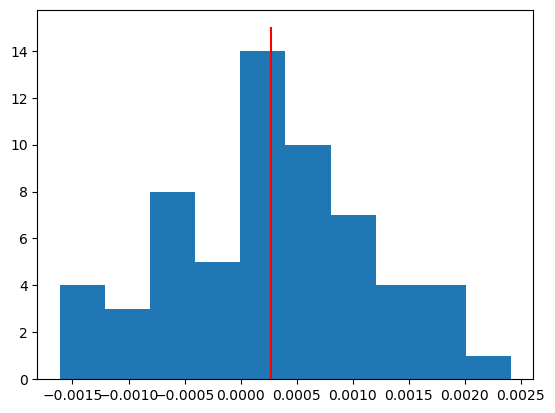

In [12]:
mean_discrepancy = np.mean(E_p)
plt.hist(E_p)
plt.vlines(mean_discrepancy, color='red', label='Mean Discrepancy', ymin=0, ymax=15)
print("Mean discrepancy:", mean_discrepancy)

### Pas 3 definim els errors i calculem la incertesa

Sabem que la incertesa es calcula amb la següent expressió, la propagació d'errors:
$$U_x = \sqrt{\sum_{i} (\frac{\partial x}{\partial i} U_i)^{2}}$$ On $i$ són les variables i $U_i$ els errors d'aquestes.

In [13]:
valors_u = {
    u_q : 0.1*1e-3,
    u_r : 7.304*1e-12,
    u_v : 1e-4,
    u_o : 0.0005/100
}

In [14]:
display(Math(f"U_x(Q, R, V, O, t) = {sp.latex(U_x)}"))

<IPython.core.display.Math object>

In [15]:
# Substituïm els valors
U_x_t = U_x.subs(valors_validacio).subs(valors_u)
display(Math(f"U_x(t) = {sp.latex(U_x_t)}"))

<IPython.core.display.Math object>

In [16]:
fUx = sp.lambdify(t, U_x_t)
uncertainty_values = fUx(times) 

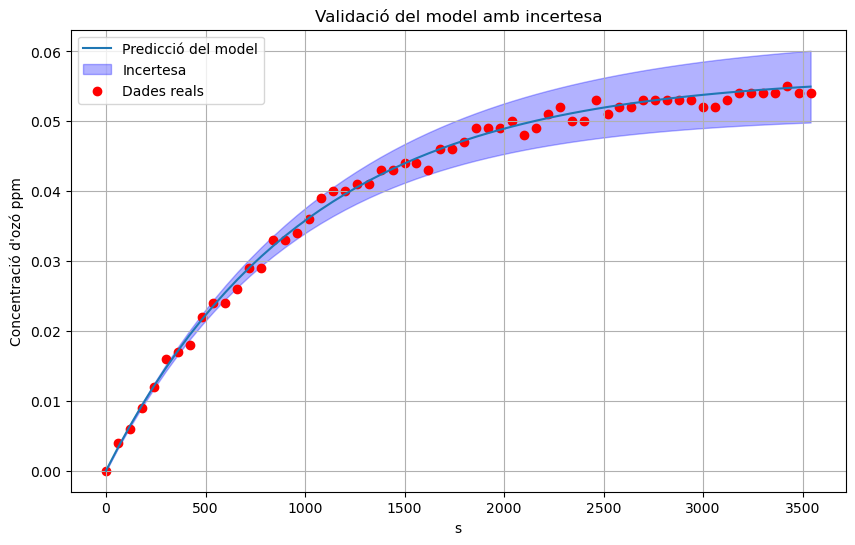

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(times, prediccions, label='Predicció del model')
plt.fill_between(times, prediccions - uncertainty_values, prediccions + uncertainty_values, color='blue', alpha=0.3, label='Incertesa')
plt.scatter(times, data['Concentració (ppm)'], color='red', label='Dades reals')
plt.xlabel('s')
plt.ylabel('Concentració d\'ozó ppm')
plt.title('Validació del model amb incertesa')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


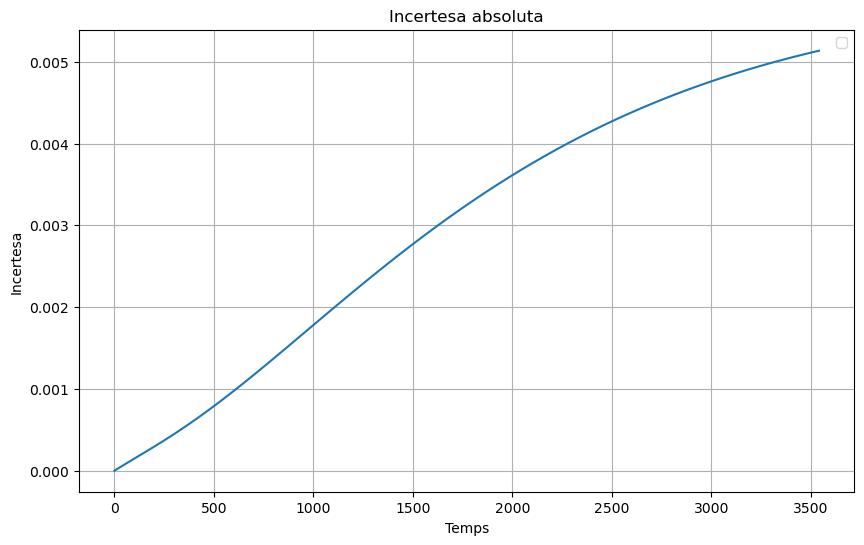

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(data['t (s)'],uncertainty_values)
plt.title('Incertesa absoluta')
plt.xlabel('Temps')
plt.ylabel('Incertesa')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
#incertesa relativa
#plt.plot(times, uncertainty_values/prediccions)
#plt.show()

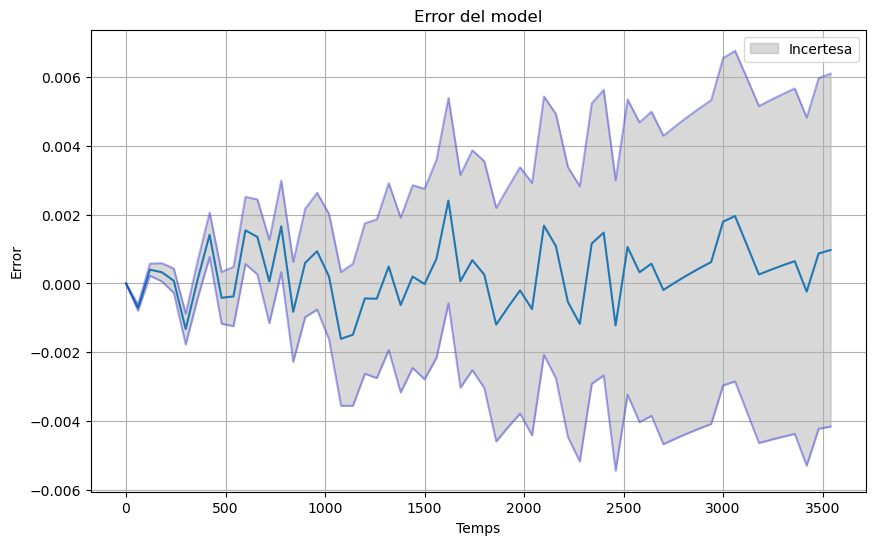

In [20]:
#Error del model 
plt.figure(figsize=(10, 6))
plt.plot(data['t (s)'],E_p+uncertainty_values,color='blue',alpha=0.3)
plt.plot(data['t (s)'],E_p)
plt.plot(data['t (s)'],E_p-uncertainty_values,color='blue',alpha=0.3)
plt.fill_between(data['t (s)'],
                 E_p - uncertainty_values,
                 E_p + uncertainty_values,
                 color='gray', alpha=0.3, label='Incertesa')
plt.title('Error del model')
plt.xlabel('Temps')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

Aleshores, podem considerar que el model queda validat, ja que, tal com es mostra a la gràfica "Validació del model amb incertesa", tots els valors reals es troben dins de l’interval d’incertesa associat a la predicció del model.

Això implica que el model no només descriu adequadament el comportament observat, sinó que també inclou la incertesa de manera realista, assegurant que el valor real de la concentració d’ozó per a cada instant de temps es troba dins de la banda d’incertesa mostrada.

A més, a la gràfica "Incertesa total de les prediccions", s’observa clarament com la incertesa augmenta amb el temps. Aquest fet és conseqüència de la propagació dels errors dels paràmetres del model i de la incertesa de mesura (
±
0.001
 
ppm
±0.001ppm). Inicialment, la incertesa és de 0.001, però al final del procés és unes 5 vegades més gran, fet que evidencia com la precisió disminueix amb el temps.

Per tant, es conclou que el model és coherent amb les dades experimentals i les seves incerteses, i per tant queda validat. A continuació, es realitzarà una anàlisi crítica sobre l’evolució de l’ozó a l’interior de l’habitació.

### Cas de l'habitació

In [21]:
valors = {
    Q : 1e-3,
    V : 125.4,
    O : 20.9476/100,
    R : 1/(3.7*1e9),
}
temps = np.linspace(0, 1000000, 60)

In [24]:
xt_h = xt.subs(valors)
fxth = sp.lambdify(t, xt_h.subs(valors))
xt_h

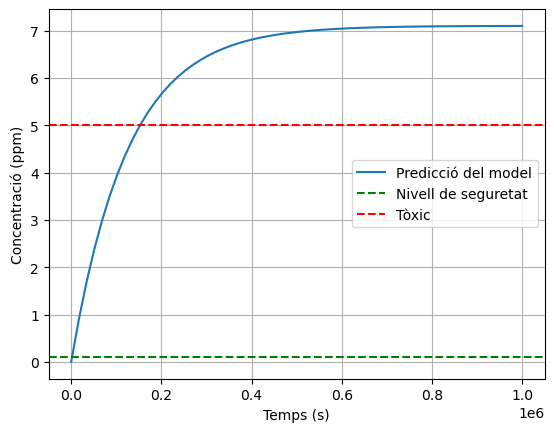

In [26]:
dph = fxth(temps)

plt.plot(temps, dph, label='Predicció del model')  # Dibuixa la predicció
plt.axhline(y=0.1, color='green', linestyle='--', label='Nivell de seguretat')  # Línia horitzontal
plt.axhline(y=5, color='red', linestyle='--', label='Tòxic')  # Línia horitzontal


plt.xlabel('Temps (s)')
plt.ylabel('Concentració (ppm)')
plt.legend()
plt.grid(True)
plt.show()